# Comparing beamconv and ducc
In this script, we run some tests to verify the good agreement of the time-ordered data (TOD) returned by ducc and beamconv.

Note that there are some discrepancies in the conventions assumed by the two codes. In particular,
- $\psi_\texttt{beamconv} = 180 - \psi_\texttt{ducc}$;
- If $q_\texttt{beamconv}=\{q_0,q_1,q_2,q_3\}$, ducc seems to need $q_\texttt{ducc} = \{-q_1,q_2,q_3,q_0\}$.

Everytime we deal with these discrepancies in the code, we'll highlight it with a <tt>#CONVENTIONS!</tt> comment.

## 1. One boresight detector

First, we consider the simpler case of a detector at boresight.

### Everything random

This section is based on [comparison_script.py](https://github.com/AdriJD/beamconv/blob/muellerconvolver_comparison/comparison_script.py) from the muellerconvolver_comparison branch of beamconv. We consider random scanning strategy, beams and HWP Mueller matrix, and compare the TOD.

We import a few useful libraries.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import mueller_convolver
import ducc0
import utils

from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

import scanning_mod

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

And set up some variables.

In [2]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))

nside = 64
lmax = 2*nside
kmax = 18
npix = 12*nside**2

We define <b>completely random beam, sky spherical harmonics coefficients and HWP Mueller matrix</b>.

In [3]:
# completely random beam
random_blm = utils.make_full_random_alm(lmax, kmax, rng)
# completely random sky
random_slm = utils.make_full_random_alm(lmax, lmax, rng)
# completely random Mueller matrix
random_mueller = np.random.uniform(-1,1,size=(4,4))

To keep our test as general as possible, we define some <b>completely random pointings</b>

In [4]:
nptg=100
random_ptg = np.empty((nptg,3))
random_ptg[:,0]=np.random.uniform(0,np.pi,size=(nptg,))       # theta
random_ptg[:,1]=np.random.uniform(0,2*np.pi,size=(nptg,))     # phi
random_ptg[:,2]=np.random.uniform(0,2*np.pi,size=(nptg,))     # psi
random_hwp_angles = np.random.uniform(0,2*np.pi,size=(nptg,)) # alpha

Given the specifics we just introduced, we can simulate the TOD by means of the <tt>get_beamconv_values</tt> function defined in utils.py. Note that, because the different conventions used in qpoint and MuellerConvolver, <tt>psi_beamconv = 180.-np.degrees(ptg_ducc[:,2])</tt>!

In [5]:
# get the signal from beamconv
signal_beamconv_TT = utils.get_beamconv_values(lmax=lmax, kmax=kmax, slm=random_slm, blm=random_blm, 
                                               ptg=random_ptg, hwp_angles=random_hwp_angles, mueller=random_mueller, 
                                               mu_con_hwp=True, mu_con_spin=True)

In [6]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=random_blm,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=random_ptg, alpha=random_hwp_angles)

del(fullconv)

To compare the two TOD, we print the L2 error and plot them, together with their difference.

In [7]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv_TT, signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.0077483096084764455


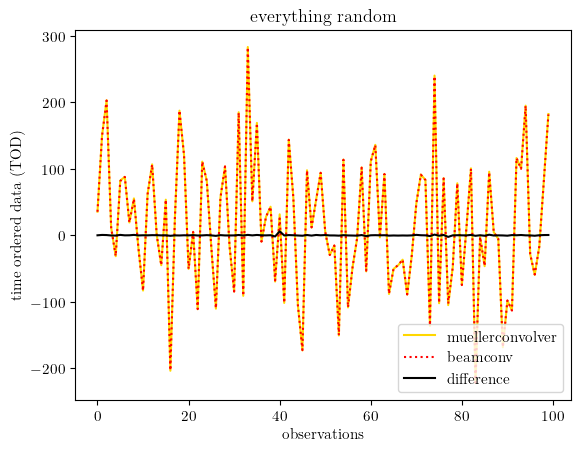

In [8]:
diff = signal_muellerconvolver-signal_beamconv_TT

# plotting diff
plt.plot(signal_muellerconvolver, color='gold', label="muellerconvolver")
plt.plot(signal_beamconv_TT, color='red', linestyle=':', label="beamconv")
plt.plot(diff, color='black', label="difference")
plt.legend(loc='lower right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random')
plt.show()

The small discrepancies between the two TOD may be due to the fact that we are running ducc with nside=64, while beamconv internally assumes nside=256. If we increase nside, the discrepancies should get lower. <font color="red">[Does this make sense? Is it worth showing explicitly?]</font> However, they are less visible for a less general (Gaussian beam), as we show in the following.

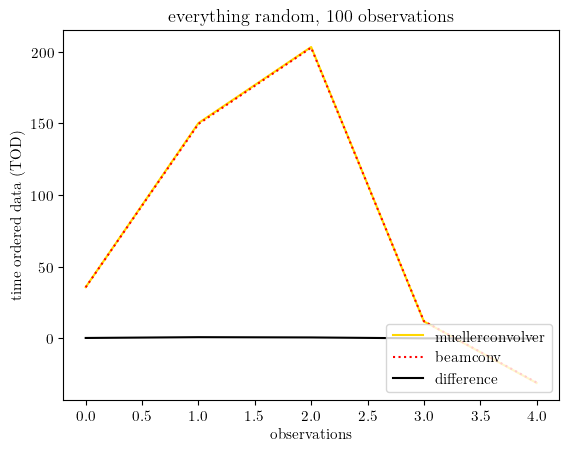

In [9]:
# plotting diff
plt.plot(signal_muellerconvolver[:5], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv_TT[:5], color='red', linestyle=':', label="beamconv")
plt.plot(diff[:5], color='black', label="difference")
plt.legend(loc='lower right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random, 100 observations')
plt.show()

### Gaussian beam (instead of random)

Given different beam specifics, we can re-run the same lines as before and compare the TOD in this case.

In [10]:
fwhm_arcmin = 5.
fwhm_rad = np.radians(fwhm_arcmin/60.)

# completely random beam
blm_gauss = utils.make_full_random_alm(lmax, kmax, rng)

# ... or use a Gauss beam
blmtmp = utils.blm_gauss_new(fwhm_rad,lmax,pol=True)
blm_gauss *= 0
blm_gauss[0:3, 0:blmtmp.shape[1]] = blmtmp

In [11]:
# get the signal from beamconv
signal_beamconv_TT = utils.get_beamconv_values(lmax=lmax, kmax=kmax, slm=random_slm, blm=blm_gauss, 
                                         ptg=random_ptg, hwp_angles=random_hwp_angles, mueller=random_mueller, 
                                         mu_con_hwp=True, mu_con_spin=True)

In [12]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=random_ptg, alpha=random_hwp_angles)

del(fullconv)

We print again the L2 error, which is less than half the previous value.

In [13]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv_TT, signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.0031168161395581763


The improvement with respect to the previous case is visible by eye in the plots below.

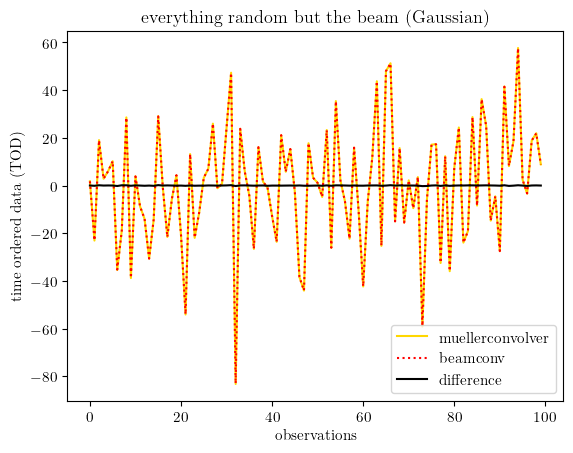

In [14]:
# plotting diff
plt.plot(signal_muellerconvolver, color='gold', label="muellerconvolver")
plt.plot(signal_beamconv_TT, color='red', linestyle=':', label="beamconv")
plt.plot(signal_muellerconvolver-signal_beamconv_TT, color='black', label="difference")
plt.legend(loc='lower right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random but the beam (Gaussian)')
plt.show()

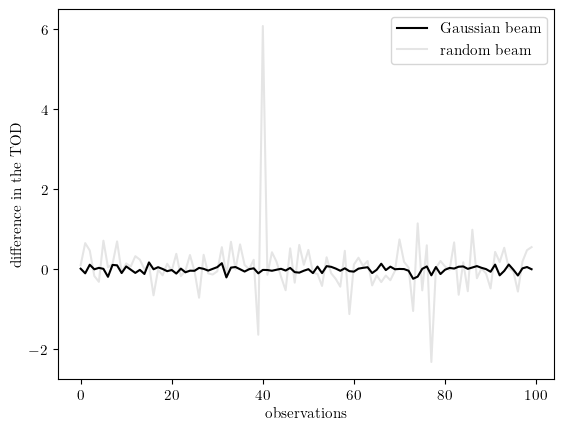

In [15]:
# plotting diff
plt.plot(signal_muellerconvolver-signal_beamconv_TT, color='black', label="Gaussian beam")
plt.plot(diff, color='black', alpha=0.1, label="random beam")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('difference in the TOD')
plt.show()

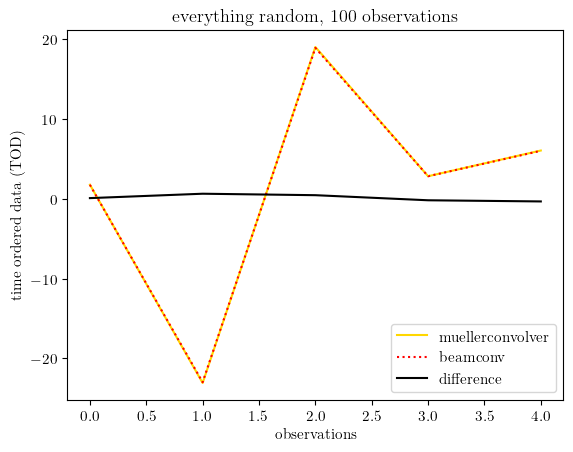

In [16]:
# plotting diff
plt.plot(signal_muellerconvolver[:5], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv_TT[:5], color='red', linestyle=':', label="beamconv")
plt.plot(diff[:5], color='black', label="difference")
plt.legend(loc='lower right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random, 100 observations')
plt.show()

### Dummy scanning strategy (instead of random)

Instead of using completely random pointings, we define a simple (non realistic) scanning strategy and test the agreement between beamconv's and ducc's TOD. This is an intermediate step before considering a LiteBIRD-like scanning strategy.

In [17]:
duration = 3600*24                    # mission duration in s (1 day)
fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

t_samp_array = np.arange(nsamp)/fsamp # array of the sampled times

def ctime_test(**kwargs):
    return np.zeros(kwargs.pop('end')-kwargs.pop('start'))

In [18]:
ptg = np.empty((nsamp,3))             # initializing pointings array
ptg[:,0]=np.pi*np.arange(nsamp)/nsamp # theta
ptg[:,1]=np.radians(55.66)            # phi
ptg[:,2]=np.arange(nsamp)*1e-4        # psi

# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
# Adjustment for difference in convention between qpoint and MuellerConvolver?
psi = 180. - np.degrees(ptg[:,2]) #CONVENTIONS!

# calculate the boresight quaternions
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def q_bore_test(**kwargs):
    return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

In [19]:
# provide HWP stuff
omega_hwp = 2*np.pi/3600                       #[rad per second]
hwp_angles = np.arange(nsamp)/fsamp*omega_hwp

Given the scanning strategy, we can introduce our boresight detector.

In [20]:
ndet = 1

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
deads = np.array([[0,1]])

And finally run beamconv and ducc.

from line 4556 of instrument.py: [1. 0. 0. 0.]


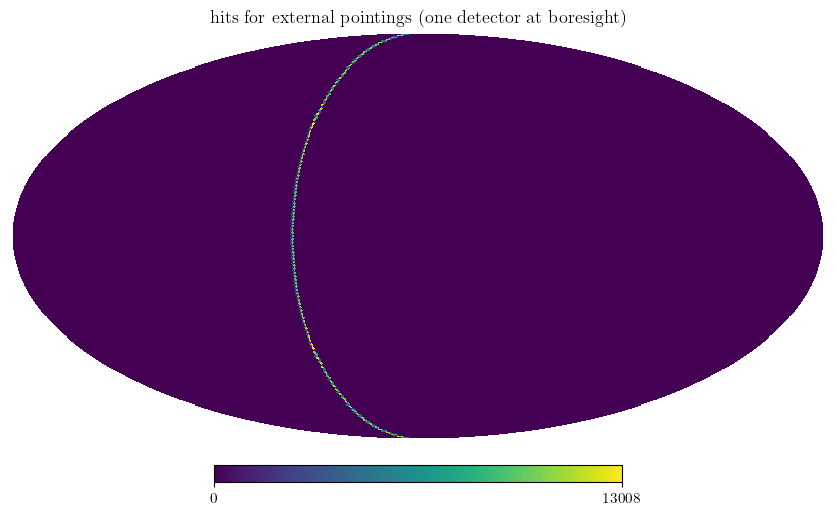

In [21]:
# prepare PO beam file
blm2 = np.zeros((blm_gauss.shape[0], hp.Alm.getsize(lmax=lmax)), dtype=np.complex128)
blm2[:,:blm_gauss.shape[1]] = blm_gauss
blmm, blmp = tools.eb2spin(blm2[1],blm2[2])
blm2[1] = blmm
blm2[2] = blmp
np.save("gaussian_beam.npy", blm2)

# setting up the beam options
beam_opts_boresight = dict(btype='PO',
                           lmax=lmax,
                           mmax=lmax,
                           deconv_q=True,
                           normalize=False,
                           po_file="gaussian_beam.npy",
                           hwp_mueller=random_mueller)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_boresight)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=np.degrees(hwp_angles))

# determine nside_spin necessary for good accuracy
nside_spin = 1
while nside_spin < 4*lmax:
    nside_spin *= 2

S_ptg.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], title=r'')
plt.title('hits for external pointings (one detector at boresight)')

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

In [22]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)

del(fullconv)

The L2 error is a bit higher than before, due to the observations near the North pole that return different values. <font color="red">[Is this okay? Looks weird!]</font> In fact, the situation improves dramatically if we compute the L2 error excluding the first 2000 observations.

In [23]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv, signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.019010253972308485


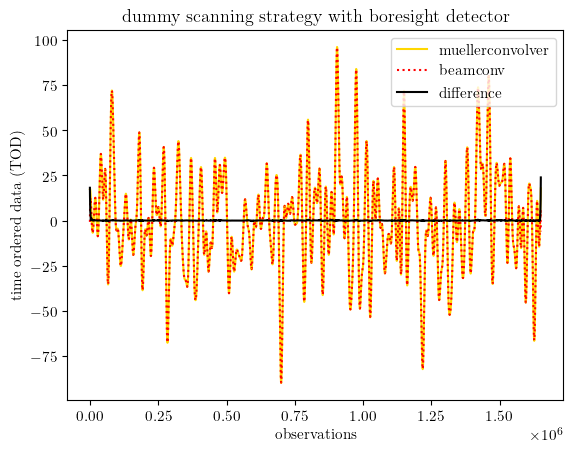

In [24]:
# plotting diff
plt.plot(signal_muellerconvolver, color='gold', label="muellerconvolver")
plt.plot(signal_beamconv, color='red', linestyle=':', label="beamconv")
plt.plot(signal_muellerconvolver-signal_beamconv, color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with boresight detector')
plt.show()

In [25]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv, signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.019010253972308485


The difference at the first samples might be due to the fact that we are looking t the North Pole. Worth checking (for South as well): rotating beam at the poles and check beamconv's vs ducc output. Expectation: Gaussian non-polarized beam, we see a constant value; Gaussian polarized beam, we se some oscillations. More complex: still oscillations (depending on the beam's mmax)

In [26]:
pixs = hp.ang2pix(nside, ptg[:,0], ptg[:,1])
print(pixs)
print(npix-1)

[    0     0     0 ... 49148 49148 49148]
49151


In [27]:
whr_wo_min = np.where(pixs!=np.min(pixs))

pix_wo_min = pixs[whr_wo_min]
idx_wo_min = np.arange(nsamp)[whr_wo_min]

whr_wo_both = np.where(pix_wo_min!=np.max(pix_wo_min))

pix_wo_both = pix_wo_min[whr_wo_both]
idx_wo_both = idx_wo_min[whr_wo_both]

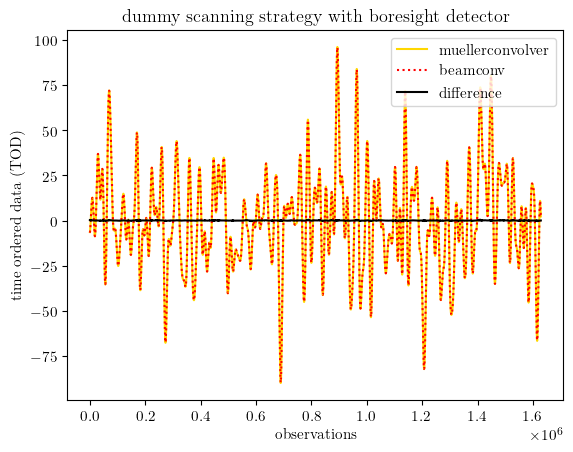

In [28]:
diff = signal_muellerconvolver-signal_beamconv

# plotting diff
plt.plot(signal_muellerconvolver[idx_wo_both], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[idx_wo_both], color='red', linestyle=':', label="beamconv")
plt.plot(diff[idx_wo_both], color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with boresight detector')
plt.show()

In [29]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv[idx_wo_both], signal_muellerconvolver[idx_wo_both]))

L2 error to beamconv + HWP + spin: 0.003317442367464932


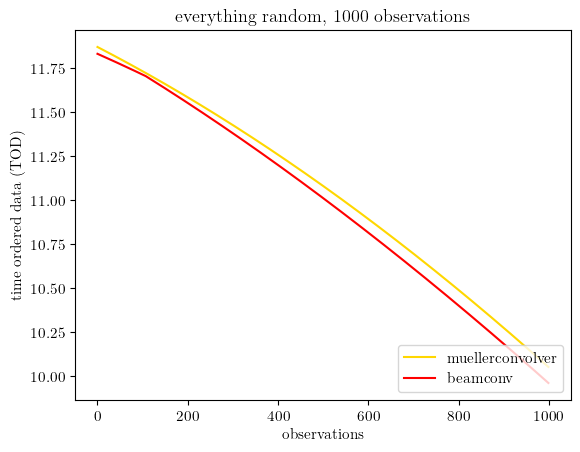

In [30]:
# plotting diff
plt.plot(signal_muellerconvolver[idx_wo_both][10000:11000], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[idx_wo_both][10000:11000], color='red', label="beamconv")
plt.legend(loc='lower right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random, 1000 observations')
plt.show()

## 2. Offset detector (instead of boresight)

We want to be able to handle offset detectors (i.e. not at boresight). This functionality has already been implemented in beamconv (only for the LiteBIRD-like branch though) and here we show how to reproduce the same results with ducc.

First, we need to define our offset quaternion.

In [31]:
off_quats = np.zeros((ndet,2,4))

off_ra, off_dec, off_pa = 10., 87., 10.
off_quats[0,0,:] = qp.QPoint().radecpa2quat(off_ra, off_dec, off_pa)

To feed the offset quaternion in beamconv, is enough to specify quats in the beam_options.

from line 4556 of instrument.py: [-2.77555756e-17  2.57792616e-02  4.54557937e-03  9.99657325e-01]


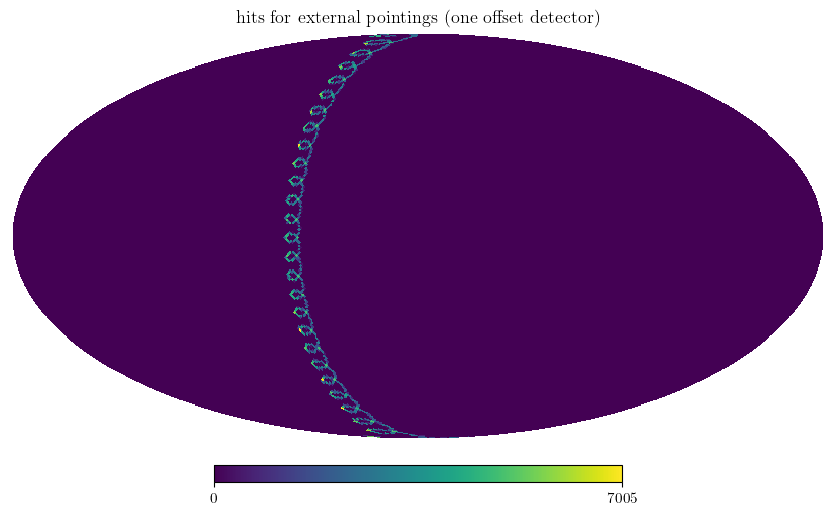

In [32]:
# setting up the beam options
beam_opts_quats = dict(btype='PO',
                       lmax=lmax,
                       mmax=lmax,
                       deconv_q=True,
                       normalize=False,
                       po_file="gaussian_beam.npy",
                       hwp_mueller=random_mueller,
                       quats=off_quats)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_quats)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=np.degrees(hwp_angles))

S_ptg.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], title=r'')
plt.title('hits for external pointings (one offset detector)')

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

For ducc, instead, we need to define the rotated quaternions.

In [33]:
ptg4ducc = np.copy(ptg)

q_bore_ducc = ducc0.misc.ptg2quat(ptg4ducc)

off_quat = np.roll(off_quats[0,0],-1) #CONVENTIONS!
off_quat[0] *= -1                     #CONVENTIONS!

new_quats = np.empty((nsamp,4))

pp = ducc0.pointingprovider.PointingProvider(t0=0., freq=fsamp, quat=q_bore_ducc, nthreads=1)
rotated_quats = pp.get_rotated_quaternions(t0=0., freq=fsamp, rot=off_quat, rot_left=True, out=new_quats)

rotated_pointings = np.empty((nsamp, 3))

for k in np.arange(nsamp):
    rotated_pointings[k] = ducc0.misc.quat2ptg(rotated_quats[k])

And ensure that theta, phi and psi are within the appropriate ranges.

In [34]:
rotated_pointings[np.where(rotated_pointings[:,1]<0),1] += 2*np.pi
rotated_pointings[np.where(rotated_pointings[:,2]<0),2] += 2*np.pi

print('theta between '+str(np.min(rotated_pointings[:,0]))+' and '+str(np.max(rotated_pointings[:,0])))
print('phi between '+str(np.min(rotated_pointings[:,1]))+' and '+str(np.max(rotated_pointings[:,1])))
print('psi between '+str(np.min(rotated_pointings[:,2]))+' and '+str(np.max(rotated_pointings[:,2])))

theta between 0.003891018376132123 and 3.1255925100043136
phi between 3.5858834732616085e-05 and 6.283149211348121
psi between 9.734115001824861e-07 and 6.2831782841795345


To test that we are indeed looking at the same pixels, we print the maximum of the difference of the two hit maps. Also, we plot the observed pixels as a function of time, and the polarization angle as a function of time.

In [35]:
pixs = hp.ang2pix(nside, rotated_pointings[:,0], rotated_pointings[:,1])
hits1 = np.bincount(pixs,minlength=npix)

print(np.max(proj[0]-hits1))

0.0


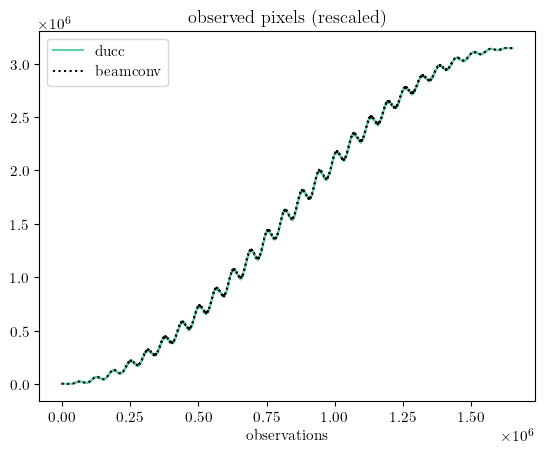

In [36]:
plt.plot(pixs*(nside_spin/nside)**2, color='mediumaquamarine', label='ducc')
plt.plot(pixels_beamconv, color='black', linestyle=':', label='beamconv')
plt.title(r'observed pixels (rescaled)')
plt.xlabel('observations')
plt.legend()
plt.show()

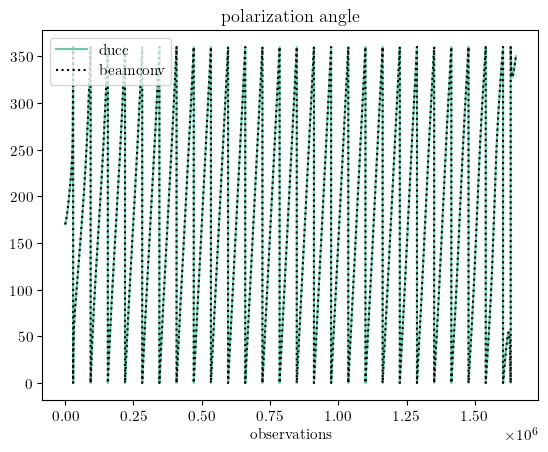

In [37]:
plt.plot(np.degrees(rotated_pointings[:,2]), color='mediumaquamarine', label='ducc')
plt.plot(pa_beamconv, color='black', linestyle=':', label='beamconv')
plt.title(r'polarization angle')
plt.xlabel('observations')
plt.legend()
plt.show()

Finally, we can compute the TOD with ducc and compare it with beamconv's output.

In [38]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=rotated_pointings, alpha=hwp_angles)

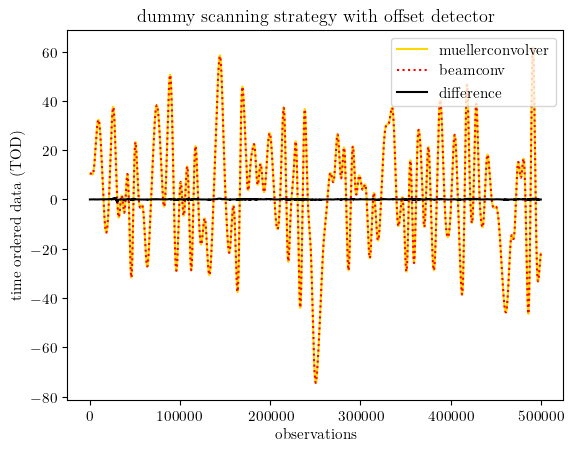

In [39]:
# plotting diff
plt.plot(signal_muellerconvolver[:500000], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[:500000], color='red', linestyle=':', label="beamconv")
plt.plot(signal_muellerconvolver[:500000]-signal_beamconv[:500000], color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with offset detector')
plt.show()

As we can see from the plot, there is very good agreement! See also the L2 error:

In [40]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(signal_beamconv, signal_muellerconvolver))

L2 error to beamconv + HWP + spin: 0.0036554984415137397


Small discrepancies due to different interpolation. If we are not looking at the center of the pixel, we expect discrepancies.

## Gaussian beam from beamconv <font color="red">[Doesn't work yet!]</font>

One thing that is not necessary but might be interesting is how to reproduce beamconv's Gaussian beam with ducc. If we don't find an answer, might be worth to delete these cells.

Take a look at healpy issue 861!

In [41]:
test_slm = random_slm.copy()
test_slm[1:] *= 0

In [42]:
# setting up the beam options
beam_opts_boresight = dict(btype='Gaussian',
                           lmax=lmax,
                           mmax=lmax,
                           deconv_q=True,
                           normalize=False,
                           fwhm=fwhm_arcmin,
                           hwp_mueller=random_mueller)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_boresight)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=np.zeros_like(hwp_angles))#np.degrees(hwp_angles))

# determine nside_spin necessary for good accuracy
nside_spin = 1
while nside_spin < 4*lmax:
    nside_spin *= 2

S_ptg.scan_instrument_mpi(test_slm, save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=False, beam_v=False, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

from line 4556 of instrument.py: [1. 0. 0. 0.]


In [44]:
fwhm_rad = np.radians(fwhm_arcmin/60.)

# initialize empty beam
blm_gauss = np.zeros_like(random_blm)

# fill everything
blmtmp = utils.Blm_gauss_new(fwhm_rad,lmax,pol=True)
blm_gauss[0:3, 0:blmtmp.shape[1]] = blmtmp

bls_gauss = utils.get_gauss_beam_from_beamconv(fwhm_rad, lmax)

# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=test_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=np.zeros_like(hwp_angles))#hwp_angles)

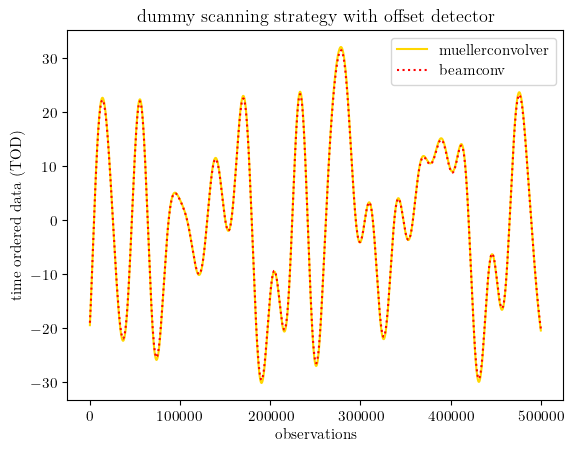

In [45]:
# plotting diff
plt.plot(signal_muellerconvolver[:500000], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[:500000], color='red', linestyle=':', label="beamconv")
#plt.plot(signal_muellerconvolver[:500000]-signal_beamconv[:500000], color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with offset detector')
plt.show()

Steps above tried with get_gauss_beam_from_beamconv for:
- constant HWP angles (set to 0) and temperature-only random sky: it works;
- constant HWP angles (set to 0) and full random slm: <font color="red"> weird!</font>

Steps above tried with blm_gauss_new for:
- constant HWP angles (set to 0) and temperature-only random sky: <font color="red">already weird!</font>

Steps above tried with Blm_gauss_new for:
- constant HWP angles (set to 0) and temperature-only random sky: it works;
- constant HWP angles (set to 0) and full random slm: <font color="red"> weird!</font>